In [1]:
import iris
import matplotlib.pyplot as plt
import cartopy as cart
import numpy as np
import iris.analysis.cartography

In [2]:
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors
import matplotlib.ticker

## Load data

In [3]:
npp_high = iris.load('data/POD0/npp_Badilla_POD0.nc')
npp_low = iris.load('data/POD0_Mandalay_new/npp_Mandalay_POD0.nc')
npp_med = iris.load('data/POD0/npp_comm_POD0.nc')
npp_control = iris.load('data/POD0/npp_control_POD0.nc')

# I processed the new run differently
npp_med_sp = npp_med[0].extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321))
npp_low_sp = npp_low[0].extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321))
npp_cont_sp = npp_control[0].extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321))
npp_high_sp = npp_high[0].extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321))

/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'npp' invalid units 'kgC m-2 s-1'
  warnings.warn(msg)
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'npp' invalid units 'kgC m-1 s-1'
  warnings.warn(msg)
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/_nc_load_rules/helpers.py:645: UserWarning: Ignoring netCDF variable 'npp' invalid units 'kgC m-2 s-1'
  warnings.warn(msg)


In [4]:
region_boundary= gpd.read_file("regions_shp/ne_10m_admin_1_states_provinces.shp")

In [5]:
#----------------------------------------------
# FUNCTION FOR NPP SUM
#---------------------------------------------

def npp(NPP_file):
    
    npp_total = NPP_file* 60 *60
    cumulative_npp = np.cumsum(npp_total.data, axis = 0)
    return cumulative_npp

## Calculate the NPP over a year

In [6]:
# GROUP BY YEAR (8760 hours)

year_groups_control = []
for i in range(0,43800,8760):
        yrs = npp_cont_sp[i:i+8760]
        year_groups_control.append(yrs)
        
year_groups_high = []
for i in range(0,43800,8760):
        yrs = npp_high_sp[i:i+8760]
        year_groups_high.append(yrs)
        
        
year_groups_low = []
for i in range(0,43800,8760):
        yrs = npp_low_sp[i:i+8760]
        year_groups_low.append(yrs)
                
        
year_groups_med = []
for i in range(0,43800,8760):
        yrs = npp_med_sp[i:i+8760]
        year_groups_med.append(yrs)

In [7]:
# REDUCE LON DIMENSION 
lon_collapsed = [cube.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321)) for cube in year_groups_control]
lon_collapsed_high = [cube.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321)) for cube in year_groups_high]
lon_collapsed_low = [cube.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321)) for cube in year_groups_low]
lon_collapsed_med = [cube.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321)) for cube in year_groups_med]

## mask nans in med data (from new processing method)
mask = np.ma.masked_invalid(lon_collapsed_med[0].data).mask
masked_med = [iris.util.mask_cube(cube, mask) for cube in lon_collapsed_med]
masked_low = [iris.util.mask_cube(cube, mask) for cube in lon_collapsed_low]
masked_high = [iris.util.mask_cube(cube, mask) for cube in lon_collapsed_high]
masked_cont = [iris.util.mask_cube(cube, mask) for cube in lon_collapsed]


# mulitply frac by npp to get actual npp
#total_npp_control = [cube*frac_regrid for cube in lon_collapsed]

In [8]:
# NPP SUM OVER EACH YEAR 

year_npp_control = []
for year in lon_collapsed:
    cumsum = npp(year)
    total = cumsum[-1]
    year_npp_control.append(total)


high_npp = []
for i, year in enumerate(lon_collapsed_high):
    cumsum = npp(year)
    total = cumsum[-1]
    high_npp.append(total)

low_npp = []
for i, year in enumerate(lon_collapsed_low):
    cumsum = npp(year)
    total = cumsum[-1]
    low_npp.append(total)

med_npp = []
for i, year in enumerate(masked_med):
    cumsum = npp(year)
    total = cumsum[-1]
    med_npp.append(total)

In [9]:
# average over the 5 years of the simulation

cont_avg = np.sum(year_npp_control, axis = 0)/5
low_avg = np.sum(low_npp, axis = 0)/5
med_avg = np.sum(med_npp, axis = 0)/5
high_avg = np.sum(high_npp, axis = 0)/5

## 1. Absolute loss

In [10]:
# Calculate loss per grid area

low_loss = cont_avg - low_avg
med_loss = cont_avg - med_avg
high_loss = cont_avg - high_avg

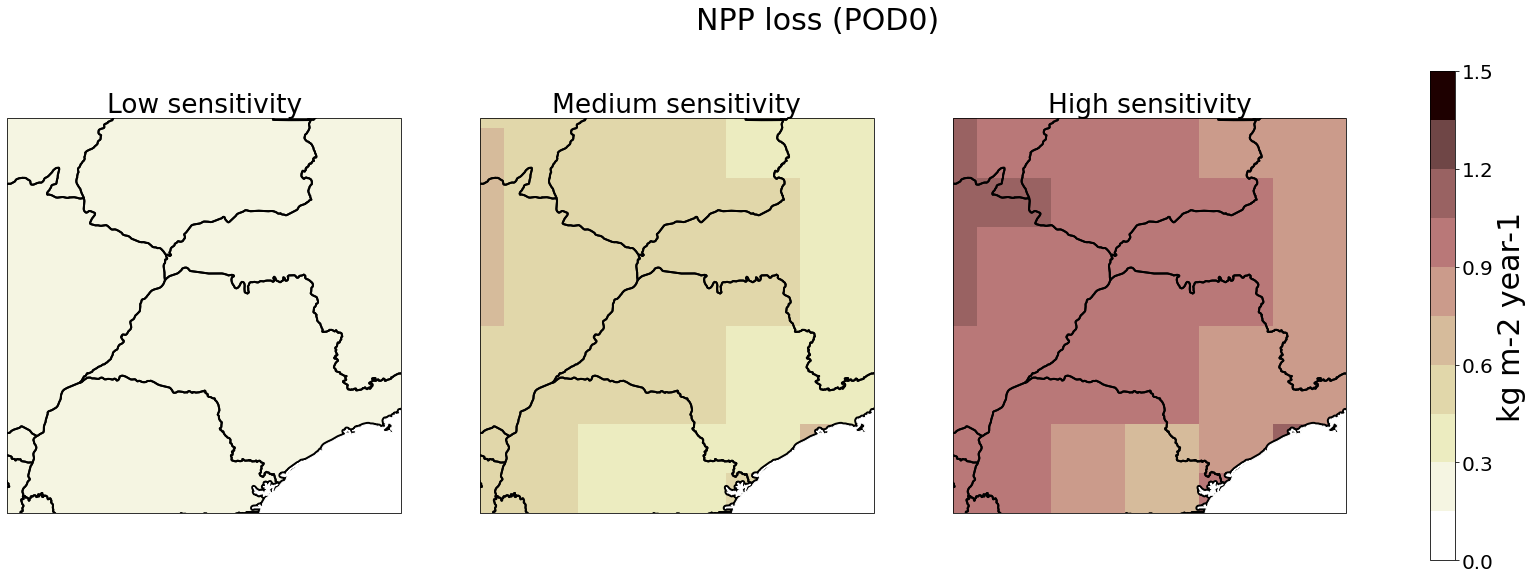

In [25]:
plt.rcParams.update({'font.size': 22})
titles = ['Low sensitivity', 'Medium sensitivity', 'High sensitivity']

fig, axs = plt.subplots(1,3, figsize = (30,9),  subplot_kw={'projection': cart.crs.PlateCarree()})

ax = axs.ravel()

y = lon_collapsed[0].coord('latitude').points
x = lon_collapsed[0].coord('longitude').points

levels = np.linspace(0,1.5,11)
cmap = plt.cm.pink_r
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
 
cf = ax[0].pcolormesh(x,y, low_loss, cmap = cmap, norm=norm)
cf = ax[1].pcolormesh(x,y, med_loss, cmap = cmap, norm=norm)
cf = ax[2].pcolormesh(x,y, high_loss, cmap = cmap, norm=norm)

for i in range(0,3):
    ax[i].coastlines(linewidth=5)
    ax[i].add_feature(cart.feature.OCEAN, zorder=100,  facecolor = 'white')

    region_boundary.plot(ax = ax[i], edgecolor="black", facecolor="None", linewidth = 2)

    ax[i].set_xlim(-55,-45)
    ax[i].set_ylim(-26,-16)

    ax[i].set_title(titles[i])

fig.suptitle('NPP loss (POD0)', fontsize = 30)

cb = plt.colorbar(cf, ax = ax.tolist())
cb.ax.tick_params(labelsize = 20)
cb.set_label('kg m-2 year-1', size = 30)

## 2. Calculate yield loss

In [20]:
# Calculate loss per grid area

low_yield = low_avg*100 / cont_avg
med_yield = med_avg*100 / cont_avg
high_yield = high_avg*100 / cont_avg

/tmp/ipykernel_3469/2746577357.py:3: RuntimeWarning: invalid value encountered in true_divide
  low_yield = low_avg*100 / cont_avg
/tmp/ipykernel_3469/2746577357.py:4: RuntimeWarning: invalid value encountered in true_divide
  med_yield = med_avg*100 / cont_avg
/tmp/ipykernel_3469/2746577357.py:5: RuntimeWarning: invalid value encountered in true_divide
  high_yield = high_avg*100 / cont_avg


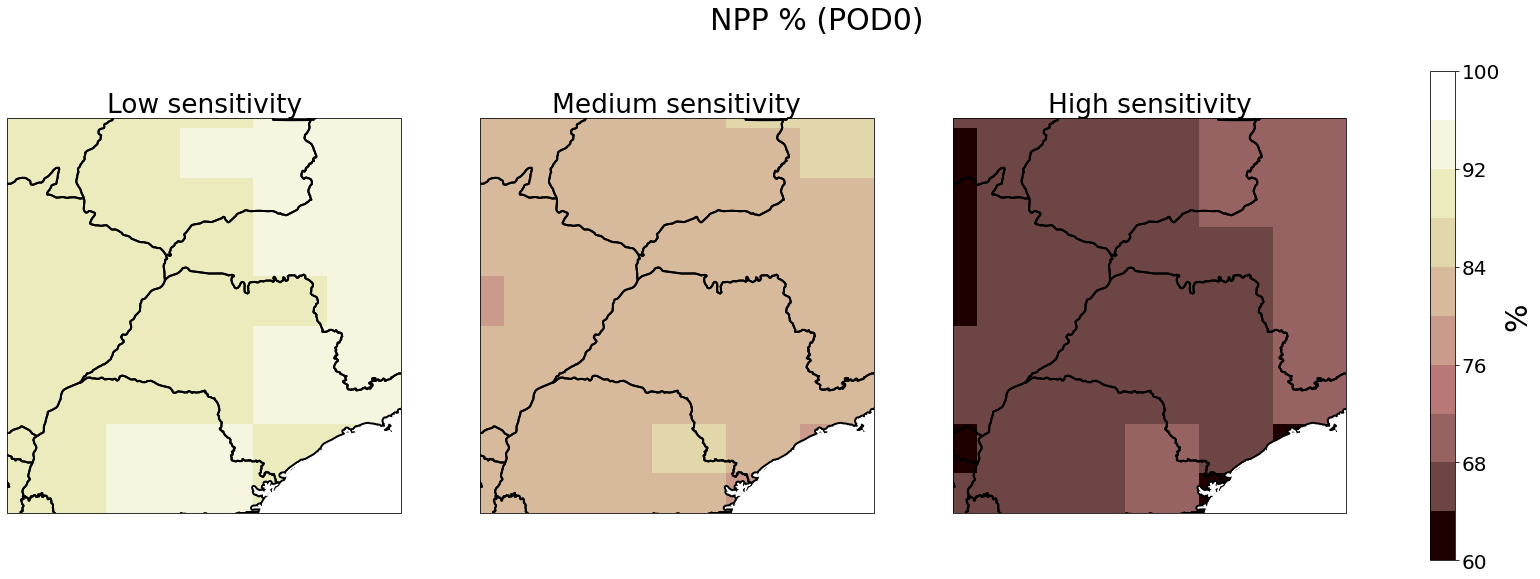

In [31]:
plt.rcParams.update({'font.size': 22})

titles = ['Low sensitivity', 'Medium sensitivity', 'High sensitivity']

fig, axs = plt.subplots(1,3, figsize = (30,9),  subplot_kw={'projection': cart.crs.PlateCarree()})

ax = axs.ravel()

y = lon_collapsed[0].coord('latitude').points
x = lon_collapsed[0].coord('longitude').points

levels = np.linspace(60,100,11)
cmap = plt.cm.pink
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
 
cf = ax[0].pcolormesh(x,y, low_yield, cmap = cmap, norm=norm)
cf = ax[1].pcolormesh(x,y, med_yield, cmap = cmap, norm=norm)
cf = ax[2].pcolormesh(x,y, high_yield, cmap = cmap, norm=norm)

for i in range(0,3):
    ax[i].coastlines(linewidth=5)
    ax[i].add_feature(cart.feature.OCEAN, zorder=100,  facecolor = 'white')

    region_boundary.plot(ax = ax[i], edgecolor="black", facecolor="None", linewidth = 2)

    ax[i].set_xlim(-55,-45)
    ax[i].set_ylim(-26,-16)

    ax[i].set_title(titles[i])

fig.suptitle('NPP % (POD0)', fontsize = 30)

cb = plt.colorbar(cf, ax = ax.tolist())
cb.ax.tick_params(labelsize = 20)
cb.set_label('%', size = 30)

## 3. Calculate actual loss using frac

In [34]:
## import frac and make the same shape as dataset
frac = iris.load('/home/users/flossie/Sugarcane/data/frac4.nc')

frac_lat = frac[0][9].extract(iris.Constraint(latitude=lambda cell: -29 <= cell <=-15))
frac_lon = frac_lat.extract(iris.Constraint(longitude=lambda cell: 285 <= cell <= 321))
frac_sugarcane = frac_lon.data

In [41]:
# get grid areas in m
lon_collapsed_high[0].coord('latitude').units = 'degrees'
lon_collapsed_high[0].coord('longitude').units = 'degrees'

lon_collapsed_high[0].coord('latitude').guess_bounds()
lon_collapsed_high[0].coord('longitude').guess_bounds()

grid_areas = iris.analysis.cartography.area_weights(lon_collapsed_high[0][0], normalize=False)


In [42]:
# multiply by grid area to get total 

low_total = low_avg*grid_areas
med_total = med_avg*grid_areas
high_total = high_avg*grid_areas
cont_total = cont_avg*grid_areas

In [43]:
# multiply by frac

low_frac = low_total*frac_sugarcane
med_frac = med_total*frac_sugarcane
high_frac = high_total*frac_sugarcane
cont_frac = cont_total*frac_sugarcane

In [44]:
# acutal loss

low_frac_loss = cont_frac - low_frac
med_frac_loss = cont_frac - med_frac
high_frac_loss = cont_frac - high_frac


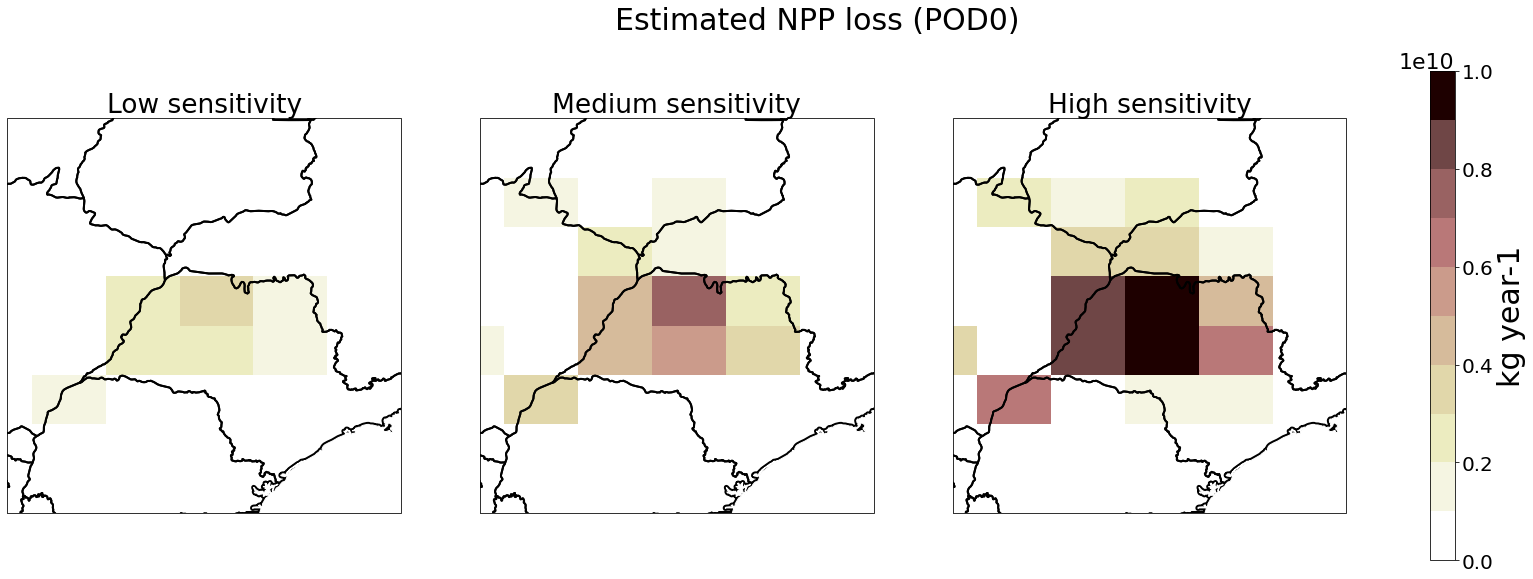

In [46]:
titles = ['Low sensitivity', 'Medium sensitivity', 'High sensitivity']

fig, axs = plt.subplots(1,3, figsize = (30,9),  subplot_kw={'projection': cart.crs.PlateCarree()})

ax = axs.ravel()

y = lon_collapsed[0].coord('latitude').points
x = lon_collapsed[0].coord('longitude').points

levels = np.linspace(0,10e9,11)
cmap = plt.cm.pink_r
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
 
cf = ax[0].pcolormesh(x,y, low_frac_loss, cmap = cmap, norm=norm)
cf = ax[1].pcolormesh(x,y, med_frac_loss, cmap = cmap, norm=norm)
cf = ax[2].pcolormesh(x,y, high_frac_loss, cmap = cmap, norm=norm)

for i in range(0,3):
    ax[i].coastlines(linewidth=5)
    ax[i].add_feature(cart.feature.OCEAN, zorder=100,  facecolor = 'white')

    region_boundary.plot(ax = ax[i], edgecolor="black", facecolor="None", linewidth = 2)

    ax[i].set_xlim(-55,-45)
    ax[i].set_ylim(-26,-16)

    ax[i].set_title(titles[i])

fig.suptitle('Estimated NPP loss (POD0)', fontsize = 30)

cb = plt.colorbar(cf, ax = ax.tolist())
cb.ax.tick_params(labelsize = 20)
cb.set_label('kg year-1', size = 30)


## Total estimated NPP loss

In [47]:
#sum over area
areaav_control = np.nansum(cont_frac)*1e-9
areaav_high = np.nansum(high_frac)*1e-9
areaav_low = np.nansum(low_frac)*1e-9
areaav_med = np.nansum(med_frac)*1e-9

Text(0.5, 1.0, 'Total sugarcane NPP and % biomass loss (POD0) ')

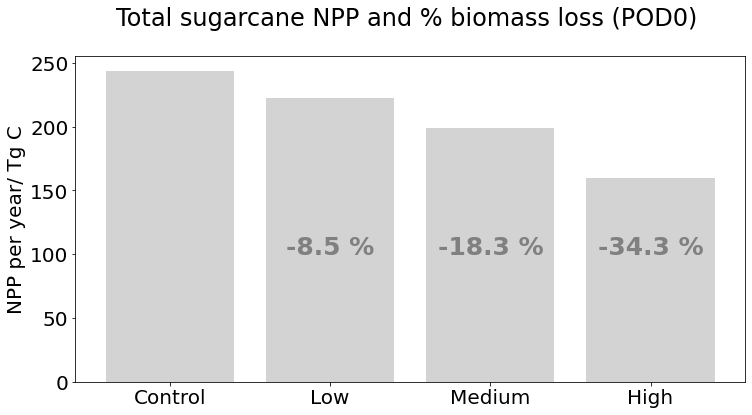

In [56]:
fig, ax = plt.subplots(figsize = (12,6))

plt.rcParams['font.size'] = '20'

ax.bar([0,1,2,3], [areaav_control, areaav_low, areaav_med, areaav_high], align='center', alpha=0.5, ecolor='black', capsize=10, facecolor = 'darkgrey')
ax.text(1, 100, '-8.5 %', horizontalalignment = 'center', fontsize = 25, fontweight = 'bold', color = 'grey')
ax.text(2, 100, '-18.3 %', horizontalalignment = 'center', fontsize = 25, fontweight = 'bold', color = 'grey')
ax.text(3, 100, '-34.3 %', horizontalalignment = 'center', fontsize = 25, fontweight = 'bold', color = 'grey')
ax.set_ylabel('NPP per year/ Tg C')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Control','Low', 'Medium', 'High'])
ax.set_title('Total sugarcane NPP and % biomass loss (POD0) ', pad = 30)

In [50]:
 1 - areaav_med/areaav_control
    #12% loss of productivity

0.18311472030660103

In [52]:
 1 - areaav_high/areaav_control
    #17% loss of productivity

0.34323118685094933

In [54]:
 1 - areaav_low/areaav_control
    #3% loss of productivity

0.08524899640121908